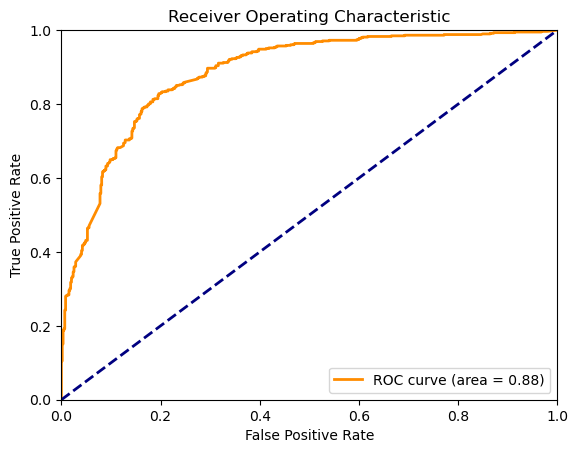

Optimal threshold for classification: 0.49
Accuracy with optimal threshold on the test set: 0.8159


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# Load data
pd.set_option('display.max_columns', None)
data_path = "COX-2.csv"  # Change this to your CSV file path
df = pd.read_csv(data_path, sep=';')

# Filter the data by activity type (IC50)
activity_type = 'IC50'
relevant_columns = ['Molecule ChEMBL ID', 'Molecule Name', 'Molecular Weight', '#RO5 Violations', 'Smiles',
                   'Standard Value', 'Standard Units', 'pChEMBL Value']
df = df[(df['Standard Type'] == activity_type) & (df['Standard Relation'].str.contains('='))][relevant_columns]

# Drop rows where 'Smiles' is missing or NaN
df = df.dropna(subset=['Smiles'])

# Convert IC50 values into binary classes (Active/Inactive) using median
df['class'] = (df['Standard Value'] <= df['Standard Value'].median()).astype(int)  # Active = 1, Inactive = 0

# Split the dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Featurizer function to generate molecular fingerprints
def featurizer(df):
    X = []
    y = []
    for i, row in df.iterrows():
        mol = Chem.MolFromSmiles(str(row['Smiles']))
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X.append(arr)
            y.append(row['class'])  # Use the binary class as the label
    return np.array(X), np.array(y)

# Featurize training and test data
X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)

# Set up hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search for Hyperparameter Tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Determine the optimal threshold based on ROC curve
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold for classification: {optimal_threshold:.2f}")

# Create binary classifications based on the optimal threshold
y_pred_binary = (y_prob >= optimal_threshold).astype(int)

# Calculate accuracy and other classification metrics using the new threshold
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy with optimal threshold on the test set: {accuracy_binary:.4f}")

# Print detailed classification report (precision, recall, F1-score) with the optimal threshold


In [3]:
import pickle

# Save the best model to a pickle file
with open('cox2_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)


In [13]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import pickle

# Load the saved model
model_path = 'cox2_model.pkl'  # Path to your saved model
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Function to featurize SMILES strings
def featurizer(smiles_list):
    X = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X.append(arr)
        else:
            print(f"Invalid SMILES string: {smiles}")
            X.append(np.zeros(1024))  # Handle invalid SMILES by appending zeros
    return np.array(X)

# Input data: Replace these with new SMILES strings
new_data = pd.DataFrame({
    'Smiles': ['CC(C(=O)C1=CC=C(C=C1)C(C)C)C(=O)O']  # Example SMILES strings
})

# Featurize the SMILES strings
X_new = featurizer(new_data['Smiles'])

# Get predicted probabilities
y_prob_new = model.predict_proba(X_new)[:, 1]  # Probability of the active class

# Set threshold (you can adjust this based on your previous optimal threshold)
threshold = 0.5
y_pred_new = (y_prob_new >= threshold).astype(int)

# Add predictions to the dataframe
new_data['Predicted Class'] = y_pred_new
new_data['Probability Active'] = y_prob_new

# Output the predictions
print(new_data)


                              Smiles  Predicted Class  Probability Active
0  CC(C(=O)C1=CC=C(C=C1)C(C)C)C(=O)O                0            0.258284
